# Making Figures 3 & 4

This notebook investigates the spectral properties of the LMRonline ensemble, and reproduces Fig 3 of the paper.

In [1]:
%load_ext autoreload
%autoreload 2
import pens
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
plt.style.use('default')
pens.set_style()

Unlike offline DA, online DA (Perkins & Hakim, 2021) links together consecutive time points via a propagator (in this case, a linear inverse model fit to CCSM4), which drastically compresses the uncertainty range. For instance, using the experiment  `production_ccsm4_pagesv2_wCoral_gis_seaslinobj_online_20m20sOHC_past1000` from the [original repository](https://zenodo.org/record/4626197#.YrvdWS1h1Mu):

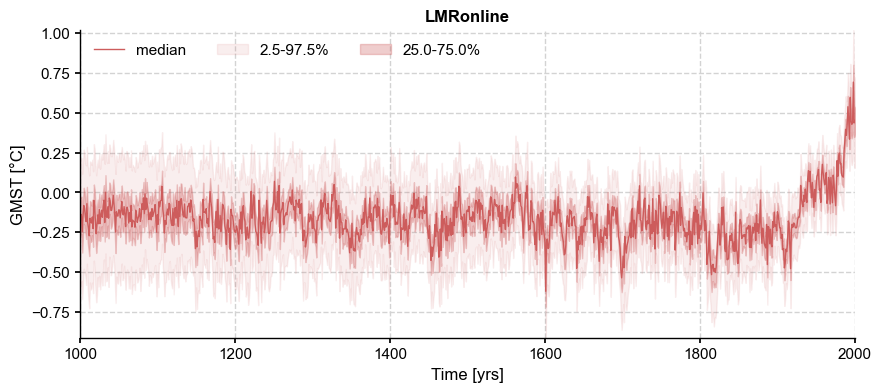

In [2]:
LMRo = pens.EnsembleTS().load_nc('../data/gmt_MCruns_ensemble_full_LMRonline.nc', var='glob_mean', time_name='year')
LMRo.label = 'LMRonline'
LMRo.value_name = 'GMST'
LMRo.value_unit = '\N{DEGREE SIGN}C'
LMRo.time_name = 'Time'
LMRo.time_unit = 'yrs'
fig, ax = LMRo.plot_qs()

### Online DA: Original ensemble

first, we subsample the online DA ensemble, which includes 50 iterations instead of the 20 used in LMR 2.1. To compare apples to apples, we need identical ensemble sizes for both. 

In [3]:
PH21_20 = LMRo.subsample(nsamples=2000)
PH21_20s = (PH21_20 - PH21_20.get_mean()) / PH21_20.get_std()

In [3]:
es_o = PH21_20.to_pyleo()  
PSD_o = es_o.spectral(method='mtm',settings={'standardize':False}) # this generates a MultiplePSD object

Performing spectral analysis on individual series: 100%|██████████| 2000/2000 [00:57<00:00, 34.56it/s]


In [4]:
es_os = PH21_20s.to_pyleo()  
PSD_os = es_os.spectral(method='mtm',settings={'standardize':False}) # this generates a MultiplePSD object

Performing spectral analysis on individual series: 100%|██████████| 2000/2000 [01:05<00:00, 30.34it/s]


apply anti-alias filter and estimate slopes

In [79]:
PSD_oaa = PSD_o.anti_alias()
PSD_osaa = PSD_os.anti_alias()
beta_o = PSD_oaa.beta_est()
beta_os = PSD_osaa.beta_est()

In [ ]:
xlabel , ylabel = LMRo.make_labels()
#xlabel = 'Year CE'

fig, axs = plt.subplots(3,1,figsize = (8,10))
# panel a
LMRo.plot_hdi(prob=0.95, ax=axs[0],color='gray',linewidth=2, title='')
LMRo.plot_traces(ax=axs[0], num_traces = 4, color= None, alpha=0.75, seed = 208, 
                xlabel = xlabel, ylabel=ylabel)
axs[0].set_title('a) ' + LMRo.label + ' HDI and traces', 
                 fontweight='bold', loc='left')
axs[0].legend(ncol=3)
#
PSD_o.plot_envelope(ax=axs[1], title='')
esm_o = PH21_20.get_median() # extract and analyze the ensemble median
esm_o = esm_o.to_pyleo(label='LMRonline median')
esm_o_spec = esm_o.spectral(method ='mtm', settings={'standardize':False})
esm_o_beta = esm_o_spec.beta_est() # estimate spectral exponent
esm_o_beta.plot(ax=axs[1], ylim=[1e-3,5])
axs[1].set_title('b) ' + LMRo.label + ' spectral density', 
                 fontweight='bold', loc='left')
#
PSD_os.plot_envelope(ax=axs[2], title='')
axs[2].set_title('c) same as b), after standardization', 
                 fontweight='bold', loc='left')
axs[2].set_xlabel(axs[1].get_xlabel())
fig.tight_layout()

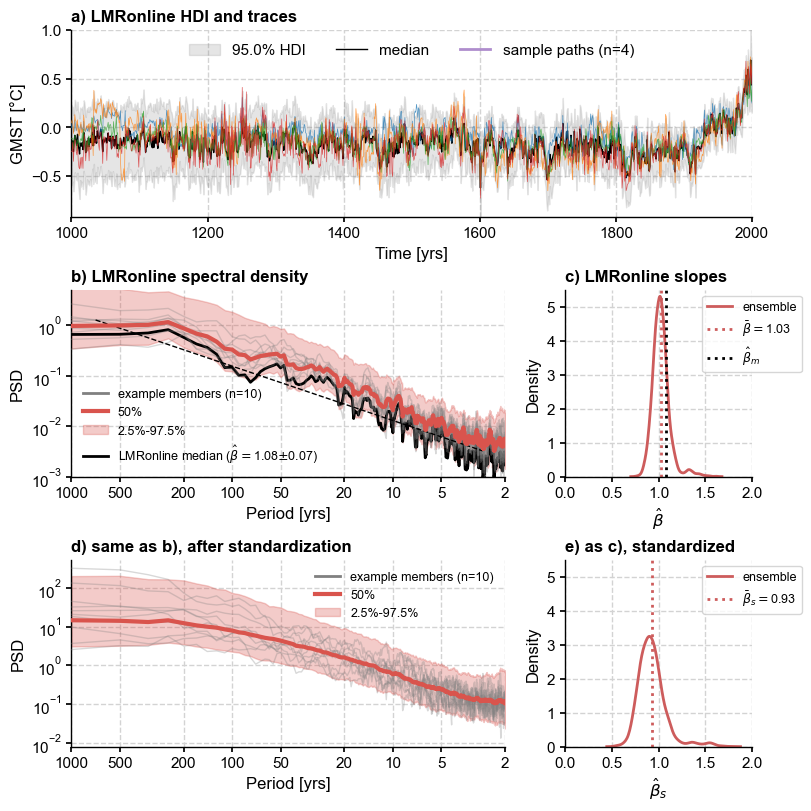

In [81]:
fig3 = plt.figure(constrained_layout=True, figsize = (8,8))
gs = fig3.add_gridspec(3, 3)
# traces
ax1 = fig3.add_subplot(gs[0, :])
xlabel , ylabel = LMRo.make_labels()
LMRo.plot_hdi(prob=0.95, ax=ax1,color='gray', median = False, title='')
LMRo.get_median().plot(ax=ax1, color='black', label = 'median')
LMRo.plot_traces(ax=ax1, num_traces = 4, color= None, alpha=0.75, seed = 208, 
                xlabel = xlabel, ylabel=ylabel)
ax1.set_title('a) ' + LMRo.label + ' HDI and traces', 
                 fontweight='bold', loc='left')
ax1.legend(ncol=3, loc = 'upper center')
# raw spectra
ax2 = fig3.add_subplot(gs[1, :-1])
PSD_oaa.plot_envelope(ax=ax2, title='')
esm_o = PH21_20.get_median() # extract and analyze the ensemble median
esm_o = esm_o.to_pyleo(label='LMRonline median')
esm_o_spec = esm_o.spectral(method ='mtm', settings={'standardize':False})
esm_o_beta = esm_o_spec.anti_alias().beta_est() # estimate spectral exponent
esm_o_beta.plot(ax=ax2, ylim=[1e-3,5], color='black', lgd_kwargs={'fontsize':9})
ax2.set_title('b) ' + LMRo.label + ' spectral density', 
                 fontweight='bold', loc='left')
# beta dist
ax3 = fig3.add_subplot(gs[1, -1])
sns.kdeplot(beta_o.beta_est_res['beta'], color = 'indianred', 
            label = 'ensemble',ax=ax3) # plot their distribution
bo = np.array(beta_o.beta_est_res['beta'])
ax3.axvline(x=bo.mean(),color='indianred', # plot its mean
            linestyle=':',label=fr'$\bar \beta = ${bo.mean():3.2f}')
ax3.axvline(x=esm_o_beta.beta_est_res['beta'],color='black',
            linestyle=':',label=r'$\hat{\beta}_m$')
ax3.legend(fontsize=9, bbox_to_anchor = [0.7, 1], frameon=True, framealpha=0.8)
ax3.set_title('c) LMRonline slopes', fontweight='bold', loc='left')
ax3.set_xlabel(r'$\hat{\beta}$')
beta_xlims = [0, 2]
beta_ylims = [0, 5.5]
ax3.set_xlim(beta_xlims)
ax3.set_ylim(beta_ylims)
# standardized spectra
ax4 = fig3.add_subplot(gs[-1, :-1])
PSD_osaa.plot_envelope(ax=ax4, title='', lgd_kwargs={'fontsize':9})
ax4.set_title('d) same as b), after standardization', 
                 fontweight='bold', loc='left')
ax4.set_xlabel(ax2.get_xlabel())
# beta dist
ax5 = fig3.add_subplot(gs[-1, -1])
sns.kdeplot(beta_os.beta_est_res['beta'], color = 'indianred',
            label = 'ensemble', ax=ax5) # plot their distribution
bos = np.array(beta_os.beta_est_res['beta'])
ax5.axvline(x=bos.mean(),color='indianred', # plot its mean
            linestyle=':',label=fr'$\bar \beta_s = ${bos.mean():3.2f}')
ax5.legend(fontsize=9, bbox_to_anchor = [0.7, 1], frameon=True, framealpha=0.8)
ax5.set_title('e) as c), standardized', fontweight='bold', loc='left')
ax5.set_xlim(ax3.get_xlim())
ax5.set_xlabel(r'$\hat{\beta}_s$')
ax5.set_xlim(beta_xlims)
ax5.set_ylim(beta_ylims)

fig.tight_layout()

In [82]:
fig3.savefig('../figures/Fig3_LMR_online.pdf',dpi=300, bbox_inches = 'tight')

## Export AR coefficients

In [10]:
from statsmodels.tsa.ar_model import AutoReg
model_order = 4
phi = np.zeros((PH21_20s.nEns,model_order+1))
sigma2 = np.zeros(PH21_20s.nEns)

for i in range(PH21_20s.nEns):
    x = PH21_20s.value[:,i]
    ts_mod = AutoReg(x, model_order) # set up the model
    ts_res = ts_mod.fit(cov_type='HAC', cov_kwds={'maxlags': model_order})  # Heteroskedasticity-autocorrelation robust covariance estimation.
    phi[i,:] = ts_res.params # export estimated parameters
    sigma2[i] = ts_res.sigma2 / x.var()  #export variance
    

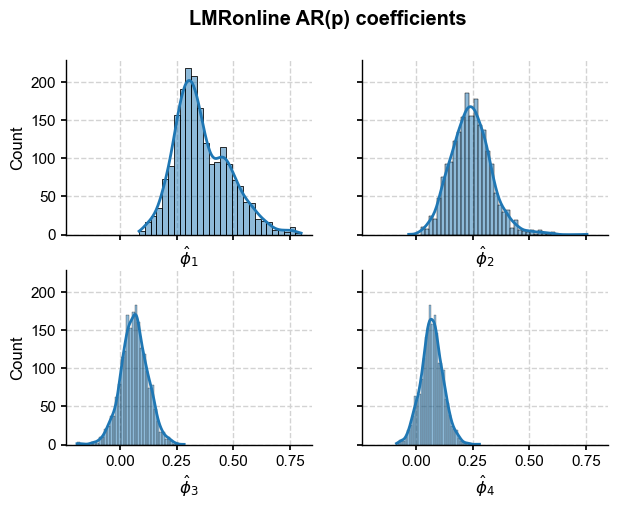

In [27]:
import seaborn as sns
fig, axs = plt.subplots(2,2,figsize=(7,5), sharex=True, sharey=True) 
axs = axs.flatten()
xmin, xmax = -1, 1

for i in range(4):
    sns.histplot(phi[:,i+1],ax=axs[i],kde=True)
    axs[i].set_xlabel(r'$\hat{\phi}_'+str(i+1)+'$',visible=True)
    #plt.setp(axs[i].get_xlabel(), )
    
#axs[1].legend(loc='right',fontsize=8, bbox_to_anchor=(1.1, 0.6))
#fig.tight_layout()
fig.suptitle('LMRonline AR(p) coefficients',fontweight='bold')
fig.savefig('../figures/LMRonline_ARfit.pdf',dpi=200)

Export to pandas

In [56]:
import pandas as pd
df = pd.DataFrame({'φ0':phi[:,0],'φ1':phi[:,1],'φ2':phi[:,2], 'φ3':phi[:,3], 'φ4':phi[:,4],'var':sigma2})
df.index.names = ['ens member']
df.head()

,φ0,φ1,φ2,φ3,φ4,var
ens member,,,,,,
0,0.051950,0.459652,0.167199,0.046081,0.073954,0.582262
1,-0.002925,0.337561,0.320492,0.065557,0.094333,0.495418
2,-0.040660,0.610942,0.088920,0.040907,0.061450,0.450393
3,0.063021,0.365478,0.277480,-0.030457,0.066657,0.671342
4,-0.166564,0.269797,0.324987,0.150546,-0.015932,0.626581


In [57]:
df.to_csv('../data/LMRonline_ARfit.csv')

## Autocovariance
(no longer used in the paper, but instructive)

In [51]:
import statsmodels as sm
import scipy
nlags = 50
j=43
x = PH21_20s.value[:,j]
acf = sm.tsa.stattools.acf(x,nlags=nlags, adjusted = True)
Sigma_acf = scipy.linalg.toeplitz(acf)

Let's try an exponential fit:

In [52]:
def monoExp(lag, A, tau):
    return A * np.exp(-lag/tau)

from scipy.optimize import curve_fit
# perform the fit
lags = np.arange(nlags+1)
p0 = (1, 10) # start with values near those we expect
params, cv = scipy.optimize.curve_fit(monoExp, lags, acf, p0)
exp_fit = monoExp(lags, params[0], params[1])

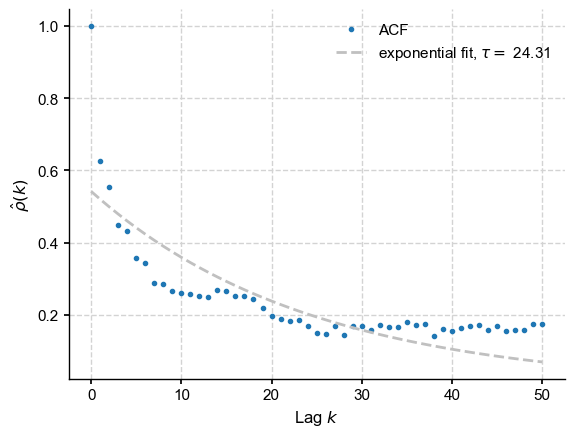

In [53]:
# plot the results
fig, ax = plt.subplots()
ax.plot(lags, acf, '.', label='ACF')
ax.plot(lags, exp_fit, '--', color = 'silver',
        label=fr'exponential fit, $\tau = $ {params[1]:3.2f}')
ax.set_ylabel(r'$\hat{\rho}(k)$')
ax.set_xlabel(r'Lag $k$')
ax.legend()

Respectable fit, except for the first value. Let us try to compute the ACF's theoretical value from the dedicated `statsmodel` [function](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_process.arma_acovf.html) 

In [36]:
arparams = np.r_[1, -phi[j,1:]] # AR model parameters
maparams = np.r_[1, 0.0]  # MA model parameters
acf_theor = sm.tsa.arima_process.arma_acf(ar = arparams, ma = maparams,lags=nlags+1)
params, cv = scipy.optimize.curve_fit(monoExp, lags, acf_theor, p0)
exp_fit = monoExp(lags, params[0], params[1])

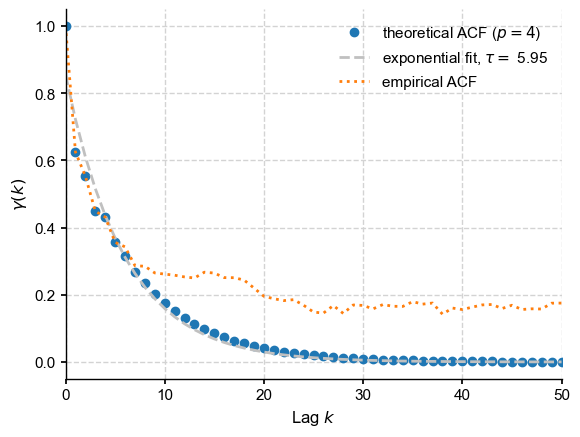

In [37]:
fig, ax = plt.subplots()
ax.plot(acf_theor, 'o', label = fr'theoretical ACF ($p={model_order:d}$)')
ax.plot(lags, exp_fit, '--', color = 'silver',
        label=fr'exponential fit, $\tau = $ {params[1]:3.2f}')
ax.plot(acf, label='empirical ACF',ls='dotted')

ax.set_xlim(0,nlags)
ax.set_ylabel(r'$\gamma(k)$')
ax.set_xlabel(r'Lag $k$')
ax.legend()
fig.savefig('../figures/lagged_correlation_ARMAtheory.pdf',dpi=200)

Now let us form $\Sigma_{ij} = \gamma(|i-j|)$:

In [39]:
rho_theor = np.zeros((PH21_20s.nt))
rho_theor[:nlags+1] = acf_theor
Sigma_theor = scipy.linalg.toeplitz(rho_theor)

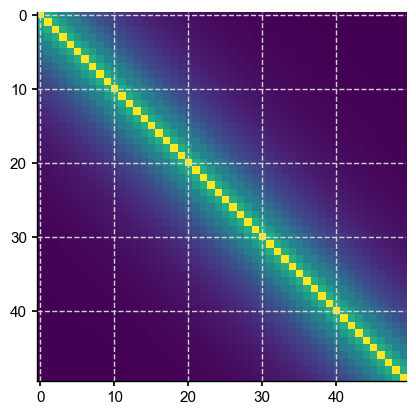

In [40]:
p = nlags
plt.imshow(Sigma_theor[:p,:p], interpolation='None')

So far so good. Let us compute the determinant:

In [41]:
np.linalg.det(Sigma_theor)

7.53919013451455e-254

In [42]:
np.linalg.det(Sigma_theor[:p,:p])

4.434493709533785e-13

Both are very small, but clearly size is a factor here: even with the same endlessly repeating exponential decay away from the diagonal, the determinant keeps shrinking as matrix size is increased. According to [Reichel & Trefethen, 1992](https://doi.org/10.1016/0024-3795(92)90374-J), Toeplitz matrices have "condition numbers that increase exponentially with the dimension", so this is expected behavior. 

What are the consequences for matrix inversion?

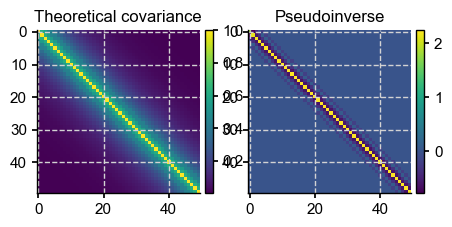

In [43]:
p = 50
f, axs = plt.subplots(1,2, figsize = (5,10))
from mpl_toolkits.axes_grid1 import make_axes_locatable

im1 = axs[0].imshow(Sigma_theor[:p,:p], interpolation='None')
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')
axs[0].set_title(r'Theoretical covariance')

iSig1 = np.linalg.pinv(Sigma_theor)
im2 = axs[1].imshow(iSig1[:p,:p], interpolation='None')
axs[1].set_title(r'Pseudoinverse')
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical');
fig.tight_layout()
#axs[1].colorbar()
#f.savefig('../figures/cov_mat.pdf',dpi=200)

At least the pseudoinverse is presentable. Since this is how [SciPy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html) computes the multivariate normal PDF when the specified covariance matrix is wonky, there is hope. In fact, it goes through the function without a hitch, but the problem is that with a size of 2001, the likelihood is vanishingly small, even for the mean (which should have the highest likelihood): 